## DM Bootcamp: June 2022
#### Christopher Waters, Princeton
### Calibration product productions, examples, and suggestions.

#### Version adapted by Sylvie

Calibration products are constructed for the Rubin using the `cp_pipe` package, and the pipelines defined therein.  Further documentation is available from that package (https://pipelines.lsst.io/v/daily/modules/lsst.cp.pipe/constructing-calibrations.html), and the best practices for calibration management and usage are defined in a number of DM Tech Notes (DMTN-148: DM Calibration Products https://dmtn-148.lsst.io/; DMTN-222: Calibration Generation, Verification, Acceptance, and Certification https://dmtn-222.lsst.io/v/u-czw-20220321/index.html; DMTN-101: Verifying LSST Calibration Data Products https://dmtn-101.lsst.io/).  All of this documentation is in development, and will likely change over the summer as other coding projects are completed.

### Notebook format:
The packages loaded in the next cell are used for visualization and light manipulation of the data products.  All processing is done separate from the notebook, to use multiprocessing and log capture that may be difficult via the notebook.  The commands listed can still be executed via the notebook, but are assumed to have already completed processing for the live demonstration.

In [1]:
#! pip install astrowidgets

In [2]:
#!jupyter labextension install @jupyter-widgets/jupyterlab-manager

In [3]:
#! jupyter labextension list

In [4]:
# Load libraries:
import numpy as np
import matplotlib.pyplot as plt

import lsst.daf.butler as dafButler
import lsst.afw.display
import lsst.cp.verify.notebooks.utils as utils

# Use astrowidgets?  This has more features, but requires additional dependencies as of 2022-06-30.
useAstrowidgets = False
if useAstrowidgets:
    import sys
#    sys.path.append("/project/czw/czw_viz/display_astrowidgets/python/")
    lsst.afw.display.setDefaultBackend("astrowidgets")
else:
    import lsst.display.matplotlib
    lsst.afw.display.setDefaultBackend("matplotlib")

In [5]:
if useAstrowidgets:
    # Create a display object:
    import IPython.display as ipydisplay
    display = lsst.afw.display.Display(dims=(800, 600))  # size in screen pixels
    ipydisplay.display(display.embed())

In [6]:
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker                         # here's where the formatter is
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from astropy.visualization import (MinMaxInterval, SqrtStretch,ZScaleInterval,PercentileInterval,
                                   ImageNormalize,imshow_norm)
from astropy.visualization.stretch import SinhStretch, LinearStretch,AsinhStretch,LogStretch

from astropy.io import fits

In [7]:
#! pip install holoviews
#! pip install xarray
#! pip install datashader

In [8]:
# Bokeh for interactive visualization
import bokeh
from bokeh.io import output_file, output_notebook, show
from bokeh.layouts import gridplot
from bokeh.models import ColumnDataSource, CDSView, GroupFilter, HoverTool
from bokeh.plotting import figure
from bokeh.transform import factor_cmap

import holoviews as hv
from holoviews import streams, opts
from holoviews.operation.datashader import rasterize
from holoviews.operation.datashader import datashade, dynspread
from holoviews.plotting.util import process_cmap

import datashader as dsh

In [9]:
# Set the holoviews plotting library to be bokeh
# You will see the holoviews + bokeh icons displayed when the library is loaded successfully
#hv.extension('bokeh')
#hv.extension('bokeh', 'matplotlib')

# Display bokeh plots inline in the notebook
#output_notebook()

In [10]:
import lsst.afw.display as afwDisplay
afwDisplay.setDefaultBackend('matplotlib')

## Do you really want to construct calibrations?
If you want to reproduce existing processed products, it may be better to start from the existing calibrations constructed at the NCSA.  The expectation (defined in DMTN-222) is that all processing for a given release will use the same calibrations, regardless of where the processing occurs.  To support that, calibrations can be exported from and imported to butler repositories.

In the absence of a more structured method at synchonizing these products, I've run the `export-calibs` commands for the current certified set of LATISS calibration products, placing the output into an archive at https://lsst.ncsa.illinois.edu/~czw/calibration_products/.  The `manifest.txt` quickly describes the contents of each calibration dump.

To import these calibrations, you (or whoever is managing shared collections and files for your butler instance) can run (as an example to import my personal defects):

    butler import $DESTINATION_REPO --transfer copy \
       --export-file ./Latiss/uczw-20220608.yaml ./Latiss/uczw-20220608 \
       -s instrument -s detector -s physical_filter

where the `--export-file` and following directory have been downloaded from this archive.  The various `-s` options list butler dimensions that should be skipped when ingesting (as they likely already exist).

If a set of acceptable calibrations are all that you need, you may be able to stop here after importing the default NCSA calibrations.  Otherwise, we'll need to construct the calibrations ourselves.

## Mon importation au CC 
Je copie les calibrations importées de Dominique dans /sps/lsst /sps/lsst/groups/auxtel/softs/shared/auxteldm_gen3/calibration_products

cp -r  /sps/lsst/users/boutigny/auxtel-gen3/import-calibs/calibration_products .


    butler import $REPO --transfer copy --export-file ./Latiss/uczw-20220608/export.yaml ./Latiss/uczw-20220608 -s instrument -s detector -s physical_filter


## Calibration types.
DM and `cp_pipe` support construction for all of the calibration types expected to be used for processing, although some algorithmic work still remains to finalize the quality of these products.  The following table lists the calibrations supported, a short description, and a note about the quality to be expected.

| Calibration Type | What it describes | Quality |
|------------------|-------------------|---------|
| defects | Bad pixels; bad columns; broken amplifiers | Very dependent on inputs; not all pixels are included |
| bias    | Extra charge originating from the detector | Good |
| dark    | Additional charge that builds over time    | Good |
| flat    | Filter throughput + detector quantum efficiency | Good |
| fringe  | Long-wavelength interference patterns created from the thin silicon of the detector | Single mode only |
| ptc     | Amplifier gain, read noise, full well.  Additional products | Good; requires a PTC ramp of many flat pairs |
| linearity | Nonlinearities between the light incident and the number of counts recorded | Reasonable.  Requires a PTC solution. |
| brighter-fatter correction | Object shape deformation by electric fields in the detector created by captured charge that repels newly absorbed charge. | Reasonable.  Requires PTC. |
| CTI correction | Inefficiencies in the charge transfer during readout. | Newly implemented |
| crosstalk | "Ghost" sources that result when the charge associated with bright sources inadvertantly ends up in a different amplifier | Requires many science exposures, or well crafted spot data |
| photodiode correction | Correction for PTC/linearity by normalizing observed counts to measured photodiode current | Newly implemented, looks very promising. |
| sky correction | Large scale background features that print through into stacks | Reasonable.  |


## Bias construction.
From scratch, bias construction iterates with other calibration products (most importantly the `defects`) to obtain a product that is as clean as possible.  To avoid this iteration, we will use my manual defects from the calibration product archive for this processing.

A standard `pipetask` command can be used to produce a bias.  The command we'll use (at NCSA) is

    RERUN=20220630a
    BUTLER_REPO=/repo/main
    pipetask --long-log run -b $BUTLER_REPO \
          -p $CP_PIPE_DIR/pipelines/Latiss/cpBias.yaml \
          -i u/czw/calibX,LATISS/raw/all,LATISS/calib \
          -o u/czw/bootcamp.20220630/biasGen.$RERUN \
          -d "instrument='LATISS' AND detector=0 AND exposure IN ($EXPOSURES)" \
          -c isr:doEmpiricalReadNoise=True >& ./bias.$RERUN.log

| Flag | Description |
|------|--------------|
| -b   | Location of the butler repository. |
| -p   | Location of pipeline definition. |
| -i   | Input collections to read from.  This is ordered to ensure the defects from `u/czw/calibX` are read before those in the default `LATISS/calib` collection. |
| -o   | Output RUN collection to write. |
| -d   | Data query to specify inputs.  See below. |
| -c   | Additional command line configuration |

### Input selection.
Ideally, the detector bias will not change, so adding a large number of inputs will give better statistics in the final calibration.  We can query the butler for a list of potential candidates:

    butler query-dimension-records $BUTLER_REPO exposure \
        --where "instrument='LATISS' AND exposure.observation_type='bias' \
                 AND exposure.target_name='Park position' \
                 AND exposure.exposure_time=0.0 AND exposure.dark_time < 0.1 \
                 AND exposure.day_obs > 20210101"
                 
This results in a list of 2300 potential exposures, of which we'll select 60 for processing:

    EXPOSURES='2021012000020, 2021012000032, 2021012000055, 2021012000061, 2021012100060, \
               2021012100134, 2021012100188, 2021012100229, 2021012700032, 2021012700037, \
               2021012700038, 2021012700052, 2021012700119, 2021012700842, 2021012700900, \
               2021012700926, 2021020100022, 2021020100032, 2021020100036, 2021020100047, \
               2021020100049, 2021020100335, 2021020100344, 2021020100369, 2021030500009, \
               2021030500015, 2021030500019, 2021030500023, 2021030500032, 2021030500046, \
               2021031100028, 2021031100032, 2021031100036, 2021031100037, 2021031100041, \
               2021031100045, 2021031100048, 2021060900011, 2021060900026, 2021060900038, \
               2021060900039, 2021060900042, 2021060900048, 2021060900049, 2021012000037, \
               2021012000059, 2021012000063, 2021012100078, 2021012700061, 2021012700423, \
               2021012700701, 2021020100072, 2021020100329, 2021020100375, 2021030500005, \
               2021030500026, 2021030500050, 2021031100004, 2021031100005, 2021031100010'

The quantum graph for this contains 61 quanta for 2 tasks; 60 of these are `IsrTask` calls, and one is a `CpCombineTask` call, to create the final bias product.

## Essai du 18/08/2022

     EXPOSURES='2021031100003, 2021031100004,  2021031100005, 2021031100006, 2021031100007, \
                2021031100008, 2021031100009, 2021031100010, 2021031100011, 2021031100012, 2021031100013, \
                2021031100014, 2021031100015, 2021031100016, 2021031100017, 2021031100018, 2021031100019, \
                2021031100020’





    /sps/lsst/groups/auxtel/softs/shared/auxteldm_gen3/data"("0")>"pipetask --long-log run -b $BUTLER_REPO \
>           -p $CP_PIPE_DIR/pipelines/Latiss/cpBias.yaml \
>       -i u/czw/calibX,LATISS/raw/all,LATISS/calib \
>       -o u/dagoret/bootcamp.20220818/biasGen.$RERUN \
>           -d "instrument='LATISS' AND detector=0 AND exposure IN ($EXPOSURES)" \
>       -c isr:doEmpiricalReadNoise=True --register-dataset-types>& ./bias.$RERUN.log


## View the Master bias

In [11]:
##### BEGIN NOTEBOOK EXCERPT #####
# This cell should be edited to match the data to be inspected.

# Which calibration type to analyse.
calibType = 'bias'
# Camera
cameraName = 'LATISS'


# Collection that the calibration was constructed in.
#genCollection = 'u/czw/bootcamp.20220630/biasGen.20220630a'
genCollection = 'u/dagoret/bootcamp.20220818/biasGen.20220818a'

In [12]:
repo = '/sps/lsst/groups/auxtel/softs/shared/auxteldm_gen3/data/butler.yaml'

#butler = dafButler.Butler("/repo/main/", collections=[verifyCollection, genCollection])
butler = dafButler.Butler(repo, collections=[genCollection])

In [13]:
registry = butler.registry
#for c in sorted(registry.queryCollections()):
#    print(c)

In [14]:
collection_bias = "u/dagoret/bootcamp.20220818/biasGen.20220818a"
datasetRefs = registry.queryDatasets(datasetType='bias', collections=collection_bias, where= "instrument='LATISS'")

In [15]:
for i, ref in enumerate(datasetRefs):
    print("======================================================= datasetType = bias =================================================================")
   
    print("fullId: ",ref.dataId.full)
    print("..................................................................................")
    #print("band:   ",ref.dataId["band"])
    print("type:   ",ref.datasetType)
    
    print("++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
    print(ref.to_simple())
    print(".  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .")
    print(ref.to_json())
    print("++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
    
    print("run = ",ref.run)
    print("isCalibration: ",ref.datasetType.isCalibration())
    
    print("isComponent:    ",ref.isComponent())
    
    print("isComposite:   ",ref.isComposite()) 
    
    if collection_bias in ref.run:
        myref = ref
        masterbias_exposure = butler.get(myref)
        msg = f"Keep index {i} for ref {myref}  run {ref.run}"
        print(msg)
    

======================================================= datasetType = bias =================================================================
fullId:  {instrument: 'LATISS', detector: 0}
..................................................................................
type:    DatasetType('bias', {instrument, detector}, ExposureF, isCalibration=True)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
id=UUID('60a63339-9f02-484d-aa50-b3fec5f20a99') datasetType=SerializedDatasetType(name='bias', storageClass='ExposureF', dimensions=SerializedDimensionGraph(names=['instrument', 'detector']), parentStorageClass=None, isCalibration=True) dataId=SerializedDataCoordinate(dataId={'instrument': 'LATISS', 'detector': 0}, records=None) run='u/dagoret/bootcamp.20220818/biasGen.20220818a/20220818T154814Z' component=None
.  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .
{"id": "60a63339-9f02-484d-aa50-b3fec5f20a99", "datasetType": {"na

In [16]:
masterbias_exposure 

In [17]:
masterbias_exposure.image.array

array([[  0.5810547 ,   2.5810547 ,   7.4833984 , ...,   1.0711496 ,
        -50.35742   , -28.071707  ],
       [  2.6845703 ,   2.8819988 ,  -6.1725726 , ...,   4.30106   ,
        -46.676434  , -29.556082  ],
       [  0.75823104,  -2.0989118 ,   3.4725168 , ...,   6.6618304 ,
        -52.700195  , -27.052456  ],
       ...,
       [  0.47307476,  -0.18339844,   5.901646  , ...,  16.914341  ,
        -46.599934  , -10.238933  ],
       [  0.2170759 ,  -2.9257812 ,  -2.4972098 , ...,  12.00865   ,
        -40.906574  , -16.277065  ],
       [  2.3568358 ,  -0.6522042 ,   3.9192243 , ...,   6.1905694 ,
        -39.733204  , -13.809431  ]], dtype=float32)

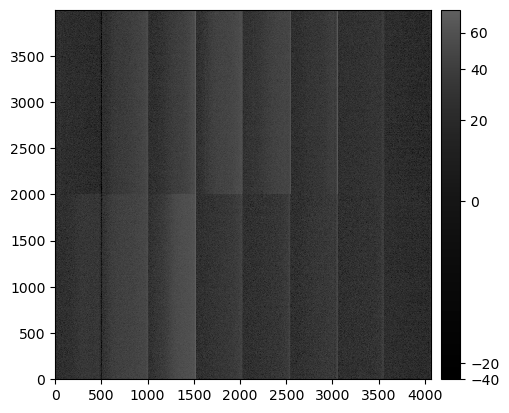

In [24]:
fig = plt.figure()
afw_display = afwDisplay.Display(1)
afw_display.scale('asinh', 'zscale')
afw_display.mtv(masterbias_exposure.image)
#plt.gca().axis('off')

In [19]:
assert False

AssertionError: 

## After construction:
We have created a bias, but have no idea if it is good or what date range to use it for.  This leads to the three strongly suggested post-construction steps:
 1. Process with cp_verify to measure residual statistics, and compare with expectations.
 2. Visualize the results, to check that there are no major concerns from the calibration.
 3. Certify the calibration into a butler CALIBRATION collection with an appropriate timescale.

## cp_verify
The goal of cp_verify is to apply the created calibration to the input exposures (or any other set of inputs of interest), calculate statistics that are important, and compare those values against tests defined by DMTN-101.

For biases, the tests pass only if the bias-processed bias exposures have means near zero (the bias signal is reliably removed) and that those images have image scatter consistent with the read noise (the bias frame is not introducing additional noise).  The `pipetask` command for this is similar to that used for construction:

    pipetask --long-log run -b $BUTLER_REPO \
        -p $CP_VERIFY_DIR/pipelines/VerifyBias.yaml \
        -i u/czw/calibX,LATISS/raw/all,LATISS/calib,u/czw/bootcamp.20220630/biasGen.$RERUN \
        -o u/czw/bootcamp.20220630/verifyBias.$RERUN \
        -d "instrument='LATISS' AND detector=0 AND exposure IN ($EXPOSURES)" \
             >& ./biasVerify.$RERUN.log

| Flag | Description |
|------|--------------|
| -b   | Location of the butler repository. |
| -p   | Location of pipeline definition. |
| -i   | Input collections to read from.  This is the same as before, but with the `biasGen` collection at the end. |
| -o   | Output RUN collection to write. |
| -d   | Data query to specify inputs.  Generally this is the same as for the bias construction.|

     pipetask --long-log run -b $BUTLER_REPO \
        -p $CP_VERIFY_DIR/pipelines/VerifyBias.yaml \
    -i u/czw/calibX,LATISS/raw/all,LATISS/calib,u/dagoret/bootcamp.20220818/biasGen.$RERUN \
        -o u/dagoret/bootcamp.20220818/verifyBias.$RERUN \
    -d "instrument='LATISS' AND detector=0 AND exposure IN ($EXPOSURES)" --register-dataset-types\
             >& ./biasVerify.$RERUN.log
 

## Verification visualization
The `cp_verify` package contains a set of example notebooks to assist in visualization.  Important cells have been copied from the bias visualization notebook for use here.


In [ ]:
##### BEGIN NOTEBOOK EXCERPT #####
# This cell should be edited to match the data to be inspected.

# Which calibration type to analyse.
calibType = 'bias'
# Camera
cameraName = 'LATISS'

# Collection name containing the verification outputs.
#verifyCollection = 'u/czw/bootcamp.20220630/verifyBias.20220630a'
verifyCollection = 'u/dagoret/bootcamp.20220818/verifyBias.20220818a'
# Collection that the calibration was constructed in.
#genCollection = 'u/czw/bootcamp.20220630/biasGen.20220630a'
genCollection = 'u/dagoret/bootcamp.20220818/biasGen.20220818a'

In [ ]:
# Get butler and camera

repo = '/sps/lsst/groups/auxtel/softs/shared/auxteldm_gen3/data/butler.yaml'

#butler = dafButler.Butler("/repo/main/", collections=[verifyCollection, genCollection])
butler = dafButler.Butler(repo, collections=[verifyCollection, genCollection])

camera = butler.get('camera', instrument=cameraName)

## Get run statistics

In [ ]:
# Get Run Statistics
runStats = butler.get('verifyBiasStats', instrument=cameraName)
runSuccess = runStats.pop('SUCCESS')

In [ ]:
# Display summary table of tests and failure counts.
utils.failureTable(runStats)

In [ ]:
# Plot focal plane, and display number of amp-level failures per detector.
# TODO: increase plot level to amplifier.
utils.plotFailures(runStats, camera, scaleFactor=8)

This table indicates that although there are occasional failures of some tests, the vast majority have no failure. The summary indicates that most failures occur on amplfier `C11`, which has the large bright defect. Let's look at the calibration itself first:

In [ ]:
if useAstrowidgets:
    # Create a display object:
    import IPython.display as ipydisplay
    display = lsst.afw.display.Display(dims=(800, 600))  # size in screen pixels
    ipydisplay.display(display.embed())

In [ ]:
# View calibration images:
continueDisplay = True
for detector in camera:
    detectorId = detector.getId()
    calib = butler.get(calibType, instrument=cameraName, detector=detectorId)
    calibArray = calib.getImage().getArray()

    # Get simple stats
    q25, q50, q75 = np.percentile(calibArray.flatten(), [25, 50, 75])
    sigma = 0.74 * (q75 - q25)
    print(f"Detector: {detector.getName()} Median: {q50}   Stdev: {sigma}")

    display.mtv(calib)
    display._scale('linear', (q50 - 3.0 * sigma), (q50 + 3.0* sigma), "")

    continueDisplay, skipNumber = utils.interactiveBlock(f"{calibType} {detector.getName()}", {})
    if continueDisplay is False:
        break

Now let's check some residuals:

In [ ]:
# This block allows the residual images to be scanned for concerns.
blinkResiduals = True
if blinkResiduals:
    continueDisplay = True
    skipNumber = 0
    for exposureId, stats in runStats.items():
        for detector in camera:
            if skipNumber > 0:
                skipNumber -= 1
                continue

            detId = detector.getId()
            residual = butler.get('verifyBiasProc', instrument=cameraName, exposure=exposureId, detector=detId)
            detStats = butler.get('verifyBiasDetStats', instrument=cameraName, exposure=exposureId, detector=detId)
            display.mtv(residual)    

            continueDisplay, skipNumber = utils.interactiveBlock(f"{exposureId} {detector.getName()}", detStats)
            if continueDisplay is False:
                break
        if continueDisplay is False:
            break
              
##### END NOTEBOOK EXCERPT #####

### This looks good!
Maybe that defect should be adjusted, maybe we should dump some of the yellow-table inputs, maybe we should etc.  This looks reasonable, the tests failures aren't catastrophic, so let's accept this bias (to distinguish it from any single input exposure, this is often referred to as a "super bias", "master bias", "The Bias", or some other similar name) and certify it.

Certification is a butler operation, and associates a given calibration product found in a specified RUN collection with a validity date range in a CALIBRATION collection.  For this bias, the command is:

    butler certify-calibrations $BUTLER_REPO \
           u/czw/bootcamp.20220630/biasGen.20220630a \
           u/czw/bootcamp.20220630/bias \
           --begin-date 2021-01-01 --end-date 2050-01-01 \
           bias

with fields:

| Field | Purpose |
|-------|---------|
| u/czw/bootcamp.20220630/biasGen.20220630a | RUN collection the bias was generated in. |
| u/czw/bootcamp.20220630/bias              | CALIBRATION collection to certify to. |
| --begin-date 2021-01-01 --end-date 2050-01-01  | A somewhat open-ended validity range. |
| bias        | The Calibration Type |

DMTN-222 suggests strongly that different calibrations and different calibration processings go to uniquely named CALIBRATION collections.  These can then be grouped into a CHAINED collection that is easier to manage:

    butler collection-chain $BUTLER_REPO u/czw/bootcamp.20220630/calib \
        u/czw/bootcamp.20220630/bias \
        u/czw/calibX \ 
        LATISS/calib
        
With this done, `u/czw/bootcamp.20220630/calib` groups our new bias, the manual defects, and any other calibrations in the default collection together:

    [u/czw/bootcamp.20220630/bias, u/czw/calibX, LATISS/calib]

## Repeat as needed.

With a bias constructed, we can move on to create darks, flats, and any other calibration type we'll need.  Let's continue with a quick flat:

### Commands for a flat:
    EXPOSURES='2021011900091, 2021011900092, 2021011900093, 2021011900094, 2021011900095, \
               2021011900096, 2021011900097, 2021011900098, 2021011900099, 2021011900100, \
               2021011900101, 2021011900102, 2021011900103, 2021011900104, 2021011900105, \
               2021011900106, 2021011900107, 2021011900108, 2021011900109, 2021011900110, \
               2021011900111, 2021011900112, 2021011900113, 2021011900114, 2021011900115, \
               2021011900116, 2021011900117, 2021011900118, 2021011900119, 2021011900120, \
               2021011900121, 2021011900122, 2021011900123, 2021011900124, 2021011900125, \
               2021011900126, 2021011900127, 2021011900128, 2021011900129, 2021011900130'
    RERUN=20220630a
    BUTLER_REPO=/repo/main

**Construction:**

    pipetask --long-log run -b $BUTLER_REPO \
          -p $CP_PIPE_DIR/pipelines/Latiss/cpFlat.yaml \
          -i u/czw/bootcamp.20220630/calib,LATISS/raw/all \
          -o u/czw/bootcamp.20220630/flatGen.$RERUN \
          -d "instrument='LATISS' AND detector=0 AND exposure IN ($EXPOSURES)" \
             >& ./flat.$RERUN.log

**Verification with a few extra exposures:**

    EXPOSURES_VERIFY='2021011900083, 2021011900088'

    pipetask --long-log run -b /repo/main \
       -p $CP_VERIFY_DIR/pipelines/VerifyFlat.yaml \
       -i LATISS/raw/all,LATISS/calib,u/czw/bootcamp.20220630/flatGen.$RERUN \
       -o u/czw/bootcamp.20220630/verifyFlat.$RERUN \
       -d "instrument='LATISS' AND detector=0 AND exposure IN ($EXPOSURES, $EXPOSURES_VERIFY)" \
        >& ./flatVerify.$RERUN.log

In [ ]:
##### BEGIN NOTEBOOK EXCERPT #####
# This cell should be edited to match the data to be inspected.

# Which calibration type to analyse.
calibType = 'flat'
physical_filter = 'empty~empty'
# Camera
cameraName = 'LATISS'

# Collection name containing the verification outputs.
verifyCollection = 'u/czw/bootcamp.20220630/verifyFlat.20220630a'
# Collection that the calibration was constructed in.
genCollection = 'u/czw/bootcamp.20220630/flatGen.20220630a'

In [ ]:
# Get butler and camera
butler = dafButler.Butler("/repo/main/", collections=[verifyCollection, genCollection])
camera = butler.get('camera', instrument=cameraName)

In [ ]:
# Get Run Statistics
runStats = butler.get('verifyFlatStats', instrument=cameraName)
runSuccess = runStats.pop('SUCCESS')

In [ ]:
# Display summary table of tests and failure counts.
utils.failureTable(runStats)

In [ ]:
utils.plotFailures(runStats, camera, scaleFactor=8)

In [ ]:
if useAstrowidgets:
    # Create a display object:
    import IPython.display as ipydisplay
    display = lsst.afw.display.Display(dims=(800, 600))  # size in screen pixels
    ipydisplay.display(display.embed())

In [ ]:
# View calibration images:
continueDisplay = True
for detector in camera:
    detectorId = detector.getId()
    calib = butler.get(calibType, instrument=cameraName, physical_filter=physical_filter, detector=detectorId)
    calibArray = calib.getImage().getArray()

    # Get simple stats
    q25, q50, q75 = np.percentile(calibArray.flatten(), [25, 50, 75])
    sigma = 0.74 * (q75 - q25)
    print(f"Detector: {detector.getName()} Median: {q50}   Stdev: {sigma}")

    display.mtv(calib)
    display._scale('linear', (q50 - 3.0 * sigma), (q50 + 3.0* sigma), "")

    continueDisplay, skipNumber = utils.interactiveBlock(f"{calibType} {detector.getName()}", {})
    if continueDisplay is False:
        break

In [ ]:
# This block allows the residual images to be scanned for concerns.
blinkResiduals = True
if blinkResiduals:
    continueDisplay = True
    skipNumber = 0
    for exposureId, stats in runStats.items():
        for detector in camera:
            if skipNumber > 0:
                skipNumber -= 1
                continue
        
            detId = detector.getId()
            residual = butler.get('verifyFlatProc', instrument=cameraName, exposure=exposureId, detector=0)
            detStats = butler.get('verifyFlatDetStats', instrument=cameraName, exposure=exposureId, detector=0)
            display.mtv(residual)
            display.scale('linear', 'zscale', None)
        
            continueDisplay, skipNumber = utils.interactiveBlock(f"{exposureId} {detector.getName()}", detStats)
            if continueDisplay is False:
                break
        if continueDisplay is False:
            break

In [ ]:
# This cell is slow, and may be too slow to be useful during a demonstration.
# Get data for mean(expTime) plot.
ampMeans = {}
for detector in camera:
    ampMeans[detector.getName()] = {}
    for amp in detector.getAmplifiers():
        ampMeans[detector.getName()][amp.getName()] = {'ID': [], 'EXPTIME': [], 'MEAN': [], 'NOISE': []}

for exposureId, stats in runStats.items():
    rr = butler.registry.queryDimensionRecords('exposure', 
                                               instrument=cameraName,
                                               exposure=exposureId)
    expTime = next(rr.__iter__()).exposure_time
    for detector in camera:
        detId = detector.getId()
        detStats = butler.get('verifyFlatDetStats', instrument=cameraName, exposure=exposureId, detector=detId)
    
        for amp in detector.getAmplifiers():
            mean = detStats['AMP'][amp.getName()]['MEAN']
            noise = detStats['AMP'][amp.getName()]['NOISE']
            ampMeans[detector.getName()][amp.getName()]['ID'].append(exposureId)
            ampMeans[detector.getName()][amp.getName()]['MEAN'].append(mean)
            ampMeans[detector.getName()][amp.getName()]['EXPTIME'].append(expTime)
            ampMeans[detector.getName()][amp.getName()]['NOISE'].append(noise)

In [ ]:
# Plot flux as a function of exposure id, to look for time trends.
continueDisplay = True
for detector in camera:
    detName = detector.getName()

    horizontalSpace = 0.0
    verticalSpace = 150
    plt.figure(figsize=(8, 8))
    fig, axes = plt.subplots(1, 2, figsize=(2 * 8, 8))
    for axis, chunk in zip(axes, [0, 1]):
        for spacer, amp in enumerate(detector.getAmplifiers()):
            axis.scatter(np.array(ampMeans[detName][amp.getName()]['ID']) + horizontalSpace * spacer,
                         np.array(ampMeans[detName][amp.getName()]['MEAN']) /
                         np.array(ampMeans[detName][amp.getName()]['EXPTIME']) + verticalSpace * spacer,
                        label=amp.getName())
        axis.set_xlabel("expId")
        axis.set_ylabel("Residual Flux (ADU/s) + Spacer")

        
        if chunk == 0:
            axis.set_xlim(2021011900090, 2021011900140)
            axis.set_title(f"{calibType} {cameraName} {verifyCollection} ConstructionSet")
        else:
            axis.set_xlim(2021011900080, 2021011900090)
            axis.set_title(f"{calibType} {cameraName} {verifyCollection} VerificationSet")
        axis.legend()
    plt.show()
    continueDisplay, skipNumber = utils.interactiveBlock(detName, {})
    if continueDisplay is False:
        break
##### END Notebook Excerpt #####

### Commands for a flat, part 2:
**Certification:**

    butler certify-calibrations $BUTLER_REPO \
       u/czw/bootcamp.20220630/flatGen.20220630a \
       u/czw/bootcamp.20220630/flat \
       --begin-date 2021-01-01 --end 2050-01-01 \
       flat

**Collection chaining:**

    butler collection-chain $BUTLER_REPO --mode=prepend \
        u/czw/bootcamp.20220630/calib \
        u/czw/bootcamp.20220630/flat

**Collection querying:**

    butler query-collections $BUTLER_REPO u/czw/bootcamp.20220630/calib
    

In [ ]:
!butler certify-calibrations /repo/main \
   u/czw/bootcamp.20220630/flatGen.20220630a \
   u/czw/bootcamp.20220630/flat \
   --begin-date 2021-01-01 --end-date 2050-01-01 \
   flat

In [ ]:
!butler collection-chain /repo/main --mode=prepend \
    u/czw/bootcamp.20220630/calib \
    u/czw/bootcamp.20220630/flat

In [ ]:
!butler query-collections /repo/main u/czw/bootcamp.20220630/calib